In [40]:
import pandas as pd
import numpy as np
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt


data = pd.read_csv("bank.csv", sep=";")
data.head()

,age,job,marital,education,default,balance,housing_loan,Personal-loan,contact,day,month,duration,Current-campaign,pdays,Previous-campaign,poutcome,subscribed
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [8]:
data.subscribed.value_counts()

,count
subscribed,
no,4000
yes,521


In [14]:
bank_subscribed_no = data[data.subscribed == "no"]
bank_subscribed_yes = data[data.subscribed == "yes"]

upsampled = resample(bank_subscribed_yes, replace=True, n_samples=2000)

new_data = pd.concat([bank_subscribed_no, upsampled])


In [21]:
new_data = shuffle(new_data)

In [23]:
X_features = list(new_data.columns)
X_features.remove("subscribed")
X_features

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing_loan',
 'Personal-loan',
 'contact',
 'day',
 'month',
 'duration',
 'Current-campaign',
 'pdays',
 'Previous-campaign',
 'poutcome']

In [27]:
X = pd.get_dummies(new_data[X_features], drop_first=True)
Y = new_data.subscribed.map(lambda x: int(x == "yes"))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### **Logistic Regression Model**

In [34]:
logit = LogisticRegression()
logit.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [35]:
pred_y = logit.predict(X_test)

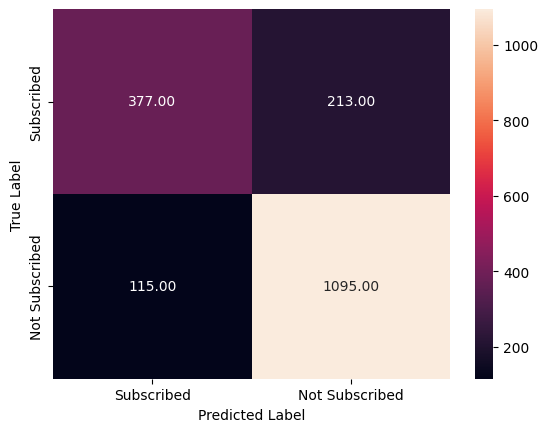

In [47]:
def draw_cm(actual, predicted):
  cm = metrics.confusion_matrix(actual, predicted, labels=[1, 0])
  sn.heatmap(cm, annot=True, fmt=".2f", xticklabels=["Subscribed", "Not Subscribed"], yticklabels=["Subscribed", "Not Subscribed"])
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()

cm = draw_cm(y_test, pred_y)

In [48]:
print(metrics.classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1210
           1       0.77      0.64      0.70       590

    accuracy                           0.82      1800
   macro avg       0.80      0.77      0.78      1800
weighted avg       0.81      0.82      0.81      1800



##### **Receiver Operating Characteristic Curve (ROC) and Area under ROC (AUC) Score**

In [60]:
predict_proba_df = pd.DataFrame(logit.predict_proba(X_test))
predict_proba_df.head()

,0,1
0,0.936479,0.063521
1,0.285365,0.714635
2,0.959172,0.040828
3,0.154793,0.845207
4,0.264134,0.735866


In [61]:
test_results = pd.DataFrame({"actual": y_test})
test_results = test_results.reset_index()
test_results["chd_1"] = predict_proba_df.iloc[:, 1:2]
test_results.head()

,index,actual,chd_1
0,3723,1,0.063521
1,1048,1,0.714635
2,1430,0,0.040828
3,3914,1,0.845207
4,3248,1,0.735866


In [55]:
auc_score = metrics.roc_auc_score(test_results.actual, test_results.chd_1)
round(float(auc_score), 2)

0.49

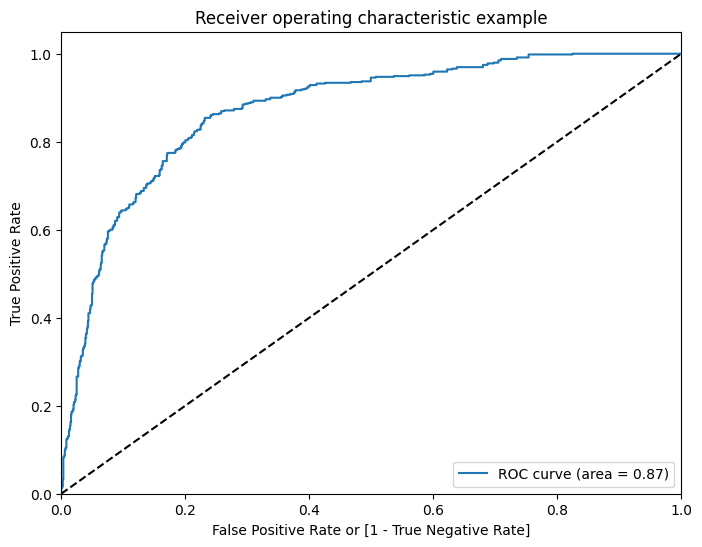

In [69]:
def draw_roc_curve(model, X_test, y_test):
  test_results = pd.DataFrame({"actual": y_test})
  test_results = test_results.reset_index()
  predict_proba_df = pd.DataFrame(logit.predict_proba(X_test))
  test_results["chd_1"] = predict_proba_df.iloc[:, 1:2]
  fpr, tpr, thresholds = metrics.roc_curve( test_results.actual,test_results.chd_1, drop_intermediate = False )
  auc_score = metrics.roc_auc_score(test_results.actual, test_results.chd_1)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % auc_score)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()

  return auc_score, fpr, tpr, thresholds
_, _, _, _ = draw_roc_curve( logit, X_test, y_test )